## GRADCAM 

### Importing libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [101]:
from layers import *
from train import *
from test import *
from models import *
from vision_dataloaders import *
import matplotlib.pyplot as plt

### DataLoader 

In [9]:
tfms = create_transform(tfm_names=['tensor'])

In [12]:
data = VisionData.load(train=True)

Files already downloaded and verified


In [14]:
u,s=data.images.mean((0,1,2))/255, data.images.std((0,1,2))/255

In [15]:
u,s

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [16]:
tfms = create_transform(tfm_names=['normalize','tensor'],norm_constants=(u,s))

In [18]:
data = VisionData.load(tfms=tfms,train=True)


Files already downloaded and verified


### Model 

In [42]:
model = ResNet()

In [44]:
model.load_state_dict(torch.load('model_87'))

<All keys matched successfully>

In [45]:
model.eval()

ResNet(
  (net): Sequential(
    (0): ConvLayer(
      (lyrs): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Sequential(
      (0): ResBlock(
        (shortcut): Sequential()
        (conv): Sequential(
          (0): ConvLayer(
            (lyrs): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (1): ConvLayer(
            (lyrs): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
        )
      )
      (1): ResBlock(
        (shortcu

### Image 

In [40]:
img = data.tfms(image=data.images[0])['image'].unsqueeze(0)

In [157]:
class GradCAM:
    
    def __init__(self,model,norm_constants=([0.5]*3,[0.5]*3)):
        self.loc,self.scale = np.array(norm_constants[0])[None,None,:],np.array(norm_constants[1])[None,None,:]
        self.model = model
        self.model.eval()
        self.forwards={}
        self.backwards={}    
        self.fhooks={}
        self.bhooks={}
        self.register_all()
        
    def forward(self,module,inp,output):
        self.forwards[id(module)]=output.data.cpu()
        
    def backward(self,module,grad_in,grad_out):
        self.backwards[id(module)]=grad_out[0].cpu()
     
    def find(self,layer_name):
        for k,v in self.forwards.items():
            for name,module in self.model.named_modules():
                if id(module)==k:
                    if name==layer_name:
                        fmap=v
                        grad=self.backwards[id(module)]
                        return fmap,grad
        print("layer name not founf")
        return "layer name not found"
        
        
    def register_all(self):
        for name,module in self.model.named_modules():
            self.fhooks[id(module)]=module.register_forward_hook(self.forward)
            self.bhooks[id(module)]=module.register_backward_hook(self.backward)
            
    def __call__(self,img,layer_name,class_num,show=False):
        # estimate model output
        preds=self.model(img)
        # convert the output of model into probabilities
        probs = F.softmax(preds,dim=1)
        # get the one hot ideal output
        one_hot = np.zeros((1, probs.size()[-1]), dtype=np.float32)
        one_hot[0][class_num] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * probs)
        # zero out the gradients and then call the backward
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        # get the forward activation and gradient of the layer 
        fmap,grad=self.find(layer_name)
        grads_val = grad.data.numpy()
        
        # get the target
        target = fmap.data.numpy()[0,:]
        
        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (32, 32))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        if show:
            show_img = img.numpy().squeeze(0).transpose((1,2,0))
            show_img = show_img*self.scale+self.loc
            #plt.imshow(show_img)
            #return show_img
            #show_img = img
            self.show_cam_on_image(show_img,cam)
        return cam
        
    
    def remove_hooks(self):
        for k,v in self.fhooks:
            v.remove()
        for k,v in self.bhooks:
            v.remove()
        
    def show_cam_on_image(self,img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        cam = np.uint8(255*cam)
        plt.imshow(cam)
        #cv2.imwrite("cam.jpg", np.uint8(255 * cam))   
        
        
        
        
        

In [54]:
model(img).argmax(dim=1).item(),data.labels[0]

(6, 6)

In [158]:
cam = GradCAM(model,norm_constants=(u,s))

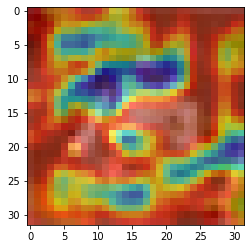

In [159]:
simg=cam(img,'net.2.1.conv.1.lyrs.1',6,show=True)

In [34]:
for m in model.named_modules():
    print(m[0])


net
net.0
net.0.lyrs
net.0.lyrs.0
net.0.lyrs.1
net.0.lyrs.2
net.1
net.1.0
net.1.0.shortcut
net.1.0.conv
net.1.0.conv.0
net.1.0.conv.0.lyrs
net.1.0.conv.0.lyrs.0
net.1.0.conv.0.lyrs.1
net.1.0.conv.0.lyrs.2
net.1.0.conv.1
net.1.0.conv.1.lyrs
net.1.0.conv.1.lyrs.0
net.1.0.conv.1.lyrs.1
net.1.1
net.1.1.shortcut
net.1.1.conv
net.1.1.conv.0
net.1.1.conv.0.lyrs
net.1.1.conv.0.lyrs.0
net.1.1.conv.0.lyrs.1
net.1.1.conv.0.lyrs.2
net.1.1.conv.1
net.1.1.conv.1.lyrs
net.1.1.conv.1.lyrs.0
net.1.1.conv.1.lyrs.1
net.2
net.2.0
net.2.0.shortcut
net.2.0.shortcut.lyrs
net.2.0.shortcut.lyrs.0
net.2.0.shortcut.lyrs.1
net.2.0.conv
net.2.0.conv.0
net.2.0.conv.0.lyrs
net.2.0.conv.0.lyrs.0
net.2.0.conv.0.lyrs.1
net.2.0.conv.0.lyrs.2
net.2.0.conv.1
net.2.0.conv.1.lyrs
net.2.0.conv.1.lyrs.0
net.2.0.conv.1.lyrs.1
net.2.1
net.2.1.shortcut
net.2.1.conv
net.2.1.conv.0
net.2.1.conv.0.lyrs
net.2.1.conv.0.lyrs.0
net.2.1.conv.0.lyrs.1
net.2.1.conv.0.lyrs.2
net.2.1.conv.1
net.2.1.conv.1.lyrs
net.2.1.conv.1.lyrs.0
net.2.1

In [35]:
model

ResNet(
  (net): Sequential(
    (0): ConvLayer(
      (lyrs): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Sequential(
      (0): ResBlock(
        (shortcut): Sequential()
        (conv): Sequential(
          (0): ConvLayer(
            (lyrs): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (1): ConvLayer(
            (lyrs): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
        )
      )
      (1): ResBlock(
        (shortcu